In [ ]:
!pip install mne
!pip install tensorflow
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 75.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

#Path to downloaded drive
base_dir= "/content/drive/MyDrive/EEG_Classification/EEG"
raw_data_dir = os.path.join(base_dir, "raw_data")
participants_file = os.path.join(raw_data_dir, "participants.csv")

In [ ]:
print("Base directory:", base_dir)
print("Raw data path:", raw_data_dir)
print("CSV path:", participants_file)
print("Participants file exists:", os.path.exists(participants_file))

Base directory: /content/drive/MyDrive/EEG_Classification/EEG
Raw data path: /content/drive/MyDrive/EEG_Classification/EEG/raw_data
CSV path: /content/drive/MyDrive/EEG_Classification/EEG/raw_data/participants.csv
Participants file exists: True


In [ ]:
window_sec =1 #duration of each window
sfreq = 256 #Hz

In [ ]:
import os
import mne
import numpy as np
import pandas as pd

In [ ]:
participants_df = pd.read_csv(participants_file, sep=",", engine="python", encoding='utf-8')
participants_df.columns = participants_df.columns.str.strip()
print("Fixed columns:", participants_df.columns.tolist())
print(participants_df.head())


Fixed columns: ['participant_id', 'Gender', 'Age', 'Group', 'MMSE']
  participant_id Gender  Age Group  MMSE
0        sub-001      F   57     A    16
1        sub-002      F   78     A    22
2        sub-003      M   70     A    14
3        sub-004      F   67     A    20
4        sub-005      M   70     A    22


In [ ]:
#Load labels
# participants_df = pd.read_csv(participants_file, delimiter='\t')
# participants_df.columns = participants_df.columns.str.strip()
label_map = {'A': 0, 'F': 1, 'C': 2}

x_all = []
y_all = []

# def segment_eeg(raw, window_sec, sfreq):
#     data = raw.get_data().T #shape ;[n_times, n_channels]
#     window_size = int(window_sec * sfreq)
#     segments = []

#     for start in range(0, len(data) - window_size + 1, window_size):
#         segment = data[start:start + window_size]
#         if segment.shape[0] == window_size:
#             segments.append(segment)

#     return np.array(segments)  #shape [n_segemnts, time, channels]

#segmenting function
def create_Segments(data, window_size=128, step=64):
    segments = []
    for start in range(0, len(data) - window_size + 1, step):
        segment = data[start:start + window_size, :]
        segments.append(segment)
    return np.array(segments)
#Loop through the subjects
for subj_id in participants_df['participant_id']:
    label_str = participants_df.loc[participants_df['participant_id'] == subj_id, 'Group'].values[0].strip()
    label = label_map.get(label_str)
    if label is None:
        print(f"Unknown label '{label_str}' for subject {subj_id}")
        continue

    subj_dir = os.path.join(raw_data_dir, subj_id, "eeg")
    try:
        set_file = f"{subj_id}_task-eyesclosed_eeg.set"
        file_path = os.path.join(subj_dir, set_file)

        raw = mne.io.read_raw_eeglab(file_path, preload=True)
        raw_sampled = raw.copy().resample(128)
        data = raw_sampled.get_data().T #[time, channels]
        def create_segments(data, window_size=128, step=64):
            segments = []
            for start in range(0, len(data) - window_size + 1, step):
                segment = data[start:start + window_size, :]
                segments.append(segment)
            return np.array(segments)

        segments= create_segments(data)
        x_all.append(segments)
        y_all.append(np.full((segments.shape[0],),label))
    except Exception as e:
        print(f"Skipping {subj_id} due to error: {e}")

print(f"Loaded {len(x_all)} subjects.")

#concatenate all subjects
x = np.concatenate(x_all)
y = np.concatenate(y_all)

print("Finished loading all data")
print("x shape:", x.shape)
print("y shape:", y.shape)

Loaded 88 subjects.
Finished loading all data
x shape: (141063, 128, 19)
y shape: (141063,)


In [ ]:
#Normalize the input data across
x = x.astype('float32')
x = (x - np.mean(x, axis=1, keepdims=True)) / (np.std(x, axis=1, keepdims=True) + 1e-6)

In [ ]:
#Traim-Test Split
from sklearn.model_selection import train_test_split

#Conver y to int labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#Split (80% train , 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [ ]:
!pip install tensorflow

In [ ]:
#Model Architecture CNN-LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, BatchNormalization, InputLayer, Reshape

model = Sequential([
    InputLayer(shape=(128, 19)),
    #Reshape: (time_steps, features) to (time_steps, features, 1)
    Reshape((128, 19, 1)),
    #CNN for spatial features
    TimeDistributed(Conv1D(32, kernel_size=3, activation='relu')),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(Flatten()),

    #LSTM for temporal sequence modeling
    LSTM(64, return_sequences=False),
    Dropout(0.5),

    Dense(65, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax') #for 3 classes

])

In [ ]:
#Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 128, 19, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 128, 17, 32)    │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 128, 8, 32)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 128, 8, 32)     │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 128, 256)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 65)             │         4,225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 65)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,855 (339.28 KB)

 Trainable params: 86,791 (339.03 KB)

 Non-trainable params: 64 (256.00 B)

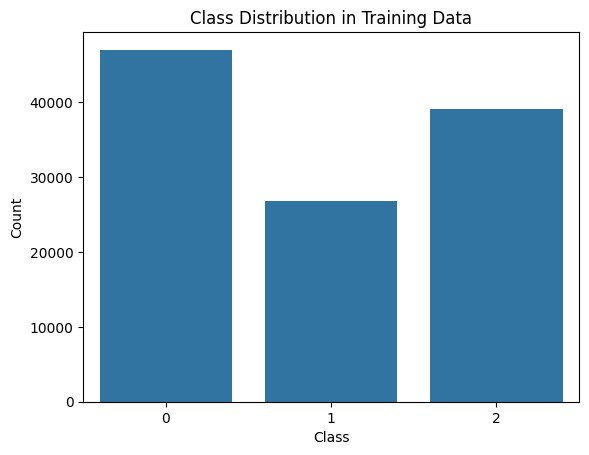

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=y_train)
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assume y_train contains integer-encoded labels (e.g., 0, 1, 2)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to a dictionary format required by Keras
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(0.8002524500418386), 1: np.float64(1.404550319866577), 2: np.float64(0.9629989930537778)}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#Train the model
history = model.fit(x_train, y_train,
                    validation_split=0.2,
                    epochs=30,
                    batch_size=128,
                    validation_data=(x_test, y_test),
                    class_weight={
                        0: 0.8002524500418386,
                        1: 1.404550319866577,
                        2: 0.9629989930537778
    })

Epoch 1/30
882/882 ━━━━━━━━━━━━━━━━━━━━ 192s 172ms/step - accuracy: 0.9428 - loss: 0.1684 - val_accuracy: 0.9224 - val_loss: 0.2221
Epoch 2/30
882/882 ━━━━━━━━━━━━━━━━━━━━ 152s 173ms/step - accuracy: 0.9465 - loss: 0.1533 - val_accuracy: 0.9222 - val_loss: 0.2226
Epoch 3/30
882/882 ━━━━━━━━━━━━━━━━━━━━ 206s 177ms/step - accuracy: 0.9476 - loss: 0.1494 - val_accuracy: 0.9270 - val_loss: 0.2211
Epoch 4/30
882/882 ━━━━━━━━━━━━━━━━━━━━ 197s 171ms/step - accuracy: 0.9489 - loss: 0.1449 - val_accuracy: 0.9270 - val_loss: 0.2158
Epoch 5/30
882/882 ━━━━━━━━━━━━━━━━━━━━ 201s 171ms/step - accuracy: 0.9522 - loss: 0.1390 - val_accuracy: 0.9274 - val_loss: 0.2332
Epoch 6/30
882/882 ━━━━━━━━━━━━━━━━━━━━ 202s 171ms/step - accuracy: 0.9541 - loss: 0.1335 - val_accuracy: 0.9294 - val_loss: 0.2058
Epoch 7/30
882/882 ━━━━━━━━━━━━━━━━━━━━ 201s 171ms/step - accuracy: 0.9524 - loss: 0.1351 - val_accuracy: 0.9295 - val_loss: 0.2256
Epoch 8/30
882/882 ━━━━━━━━━━━━━━━━━━━━ 151s 172ms/step - accuracy: 0.9559 -

In [ ]:
#Evaluate and save
loss, acc= model.evaluate(x_test, y_test)
print(f"Test Accuracy: {acc:4f}")

882/882 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9435 - loss: 0.2026
Test Accuracy: 0.943820


882/882 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     11752
           1       0.94      0.95      0.94      6695
           2       0.95      0.95      0.95      9766

    accuracy                           0.94     28213
   macro avg       0.94      0.94      0.94     28213
weighted avg       0.94      0.94      0.94     28213



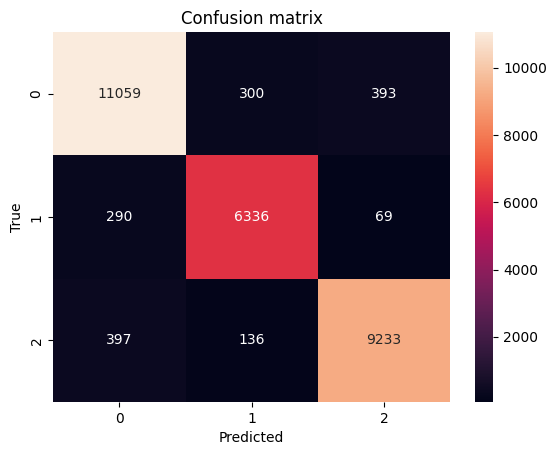

In [ ]:
#Confusion matrix and Classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(x_test).argmax(axis=1)

class_names = [str(c) for c in label_encoder.classes_]
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix")
plt.show()

In [ ]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy
topk = TopKCategoricalAccuracy(k=2)
topk.update_state(tf.keras.utils.to_categorical(y_test), model.predict(x_test))
print("Top-2 Accuracy:", topk.result().numpy())


882/882 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step
Top-2 Accuracy: 0.98957926


In [ ]:
#Save model
model.save("eeg_cnn_lstm_model.h5")

In [ ]:
model.save('eeg_cnn_lstm_model.keras')